# HR Analytics: Predicting Employee Satisfaction and Resignation

## Project overview

The goal of this project is to build two predictive tools for HR analytics:
- Predict employee job satisfaction level  
- Predict employee attrition probability  

The project also aims to identify key factors influencing satisfaction and turnover, and provide actionable recommendations to improve employee retention.

# Task 1: Predicting employee job satisfaction

## Data loading

In this task, we use three datasets: a training set with target values and a test set without target values + set of target values for self-check.

The dataset includes the following groups of features:
- Employee demographics (department, level, tenure)
- Performance metrics (supervisor evaluation, violations, promotions)
- Work characteristics (workload, satisfaction history)

The target variable is `job_satisfaction_rate`, which reflects the employee's overall level of job satisfaction.

We loaded the training and test datasets and reviewed their structure using basic summary methods.

In [1]:
!pip install --upgrade shap -q
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


import shap
from sklearn.inspection import permutation_importance

import phik
from phik import report
from phik.report import plot_correlation_matrix

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
train_job_satisfaction = pd.read_csv('data/train_job_satisfaction_rate.csv', sep = ',')

train_job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
test_features = pd.read_csv('data/test_features.csv', sep = ',')

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
test_target_job_satisfaction = pd.read_csv('data/test_target_job_satisfaction_rate.csv', sep = ',')

test_target_job_satisfaction.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [9]:
test_target_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


## Data Preprocessing

- **train_job_satisfaction**

Check and remove duplicates (excluding ID column)

In [10]:
duplicates_count = train_job_satisfaction.duplicated(
    subset=train_job_satisfaction.columns[1:]
).sum()

train_job_satisfaction = (
    train_job_satisfaction
    .drop_duplicates(subset=train_job_satisfaction.columns[1:])
    .reset_index(drop=True)
)

print(f"Removed {duplicates_count} duplicate rows")

Removed 245 duplicate rows


Review unique values for categorical features

In [11]:
categorical_columns = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

for col in categorical_columns:
    print(f"Unique values in {col}: {train_job_satisfaction[col].unique()}")

Unique values in dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Unique values in level: ['junior' 'middle' 'sinior' nan]
Unique values in workload: ['medium' 'high' 'low']
Unique values in last_year_promo: ['no' 'yes']
Unique values in last_year_violations: ['no' 'yes']


Fix incorrect category spelling

In [12]:
train_job_satisfaction['level'] = train_job_satisfaction['level'].replace(
    {'sinior': 'senior'}
)

- **test_features**

In [13]:
cat_features = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

for col in cat_features:
    print(f"Unique values in {col}: {test_features[col].unique()}")

Unique values in dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Unique values in level: ['junior' 'middle' 'sinior' nan]
Unique values in workload: ['medium' 'low' 'high' ' ']
Unique values in last_year_promo: ['no' 'yes']
Unique values in last_year_violations: ['no' 'yes']


In [14]:
test_features['level'] = test_features['level'].replace(
    {'sinior': 'senior'}
)

test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(
    {' ': np.nan}
)

The dataset was cleaned by removing duplicate records and validating categorical feature values. An identified spelling issue in the `level` column was corrected to ensure data consistency before further processing.

## Exploratory Data Analysis (EDA)

In [15]:
train_job_satisfaction.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,543971.018642,3.817044,3.463648,34457.416778,0.532554
std,257519.882511,2.557142,1.026265,15050.643870,0.226393
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322889.500000,2.000000,3.000000,22800.000000,0.350000
50%,532729.000000,3.000000,4.000000,31200.000000,0.550000
75%,770477.500000,6.000000,4.000000,44400.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [16]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [17]:
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['very low', 'low', 'middle', 'high']
train_job_satisfaction['satisfaction_level_binned'] = pd.cut(train_job_satisfaction['job_satisfaction_rate'], bins=bins, labels=labels)

Categorical features

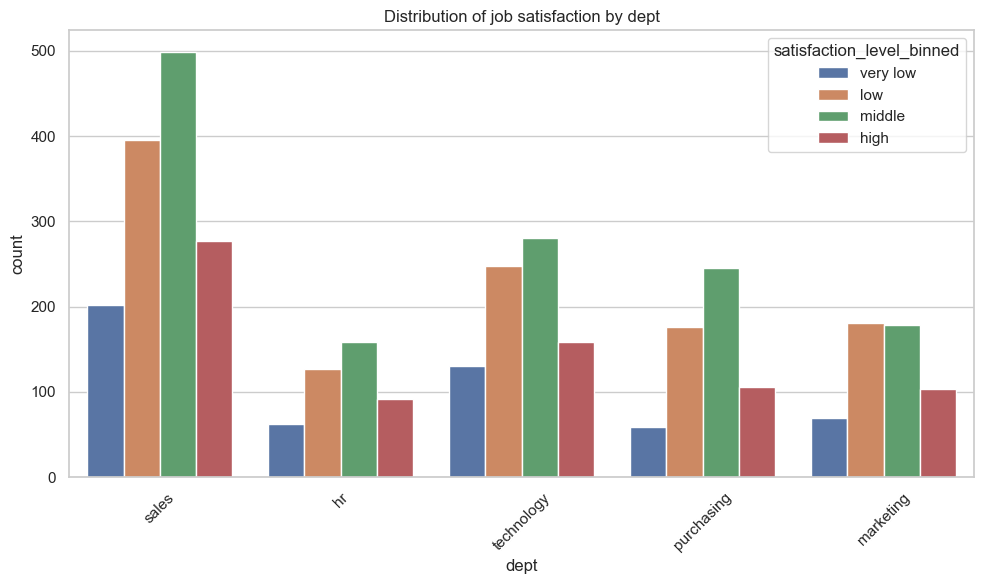

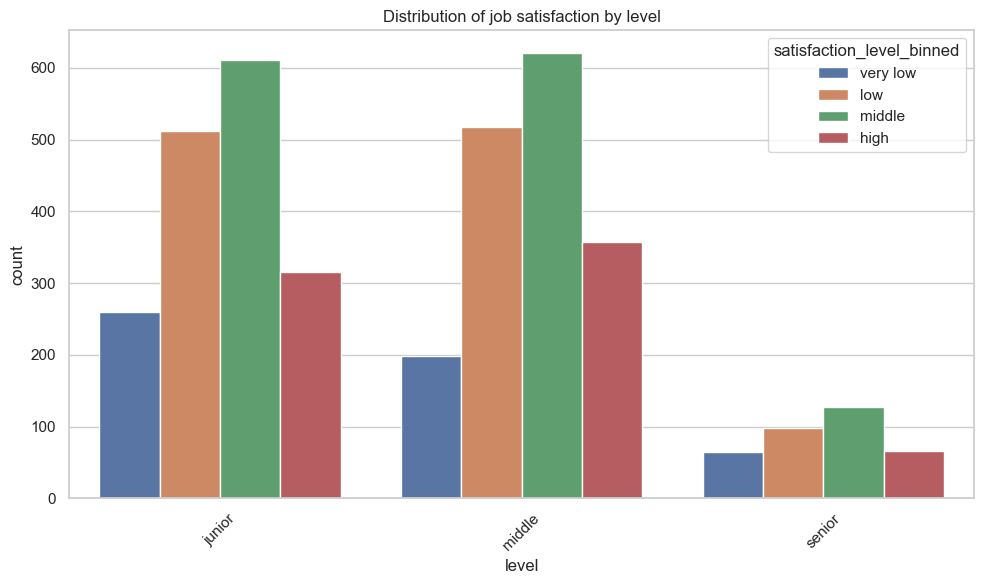

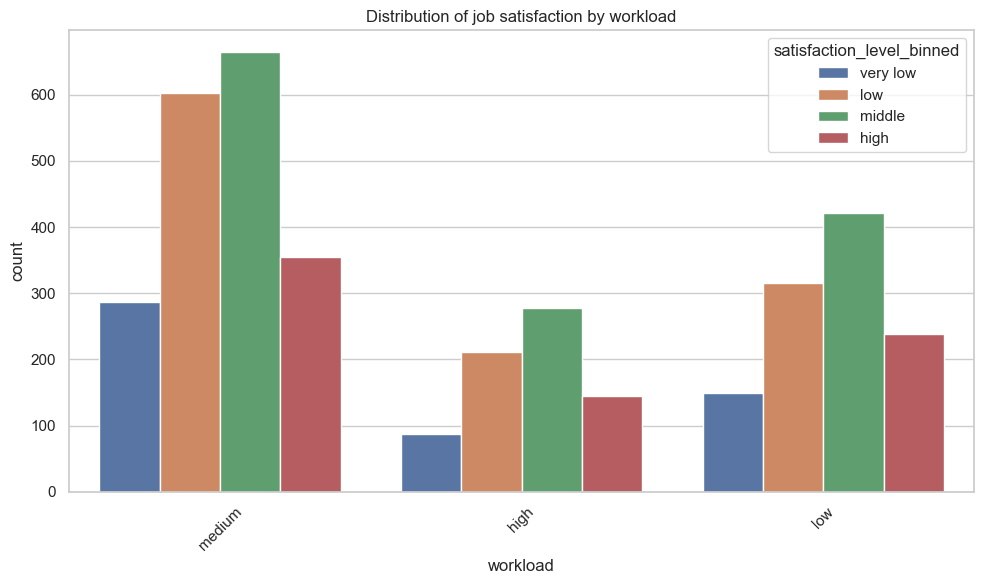

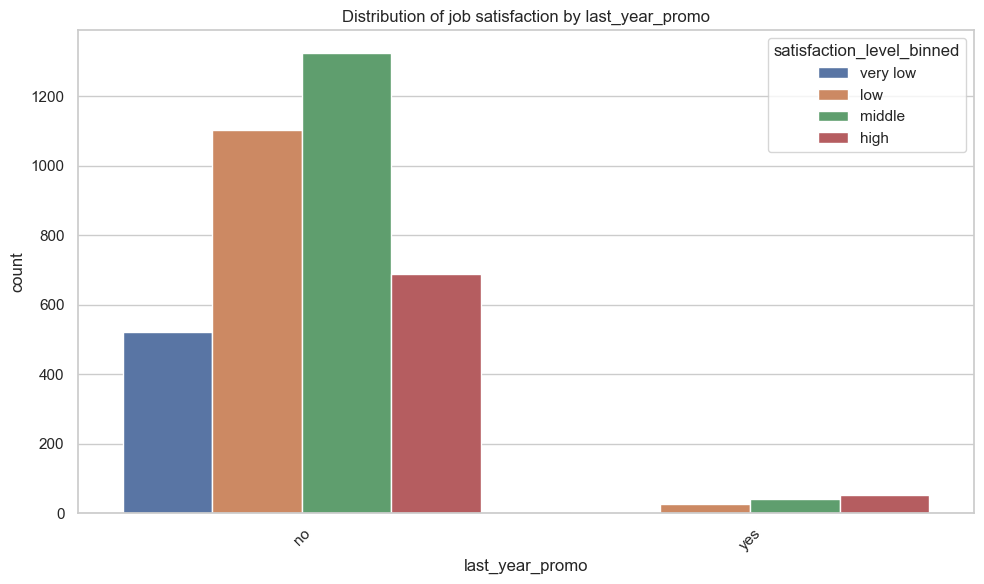

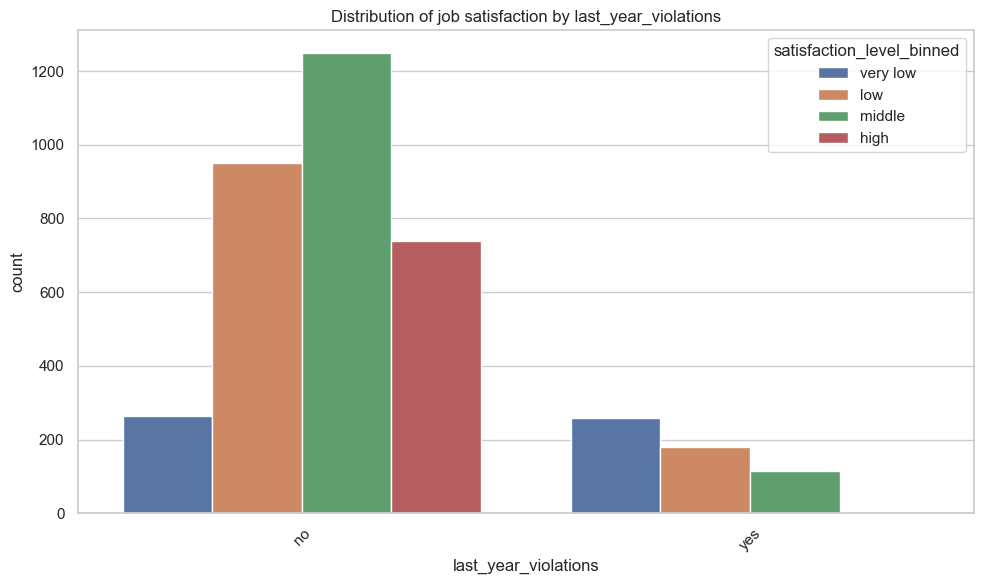

In [18]:
target = 'satisfaction_level_binned'


for col in cat_features:
    plt.figure()
    sns.countplot(data=train_job_satisfaction, x=col, hue=target)
    plt.title(f'Distribution of job satisfaction by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

Numerical features

In [19]:
num_features_num = ['salary']

In [20]:
num_features_cat = ['employment_years', 'supervisor_evaluation']

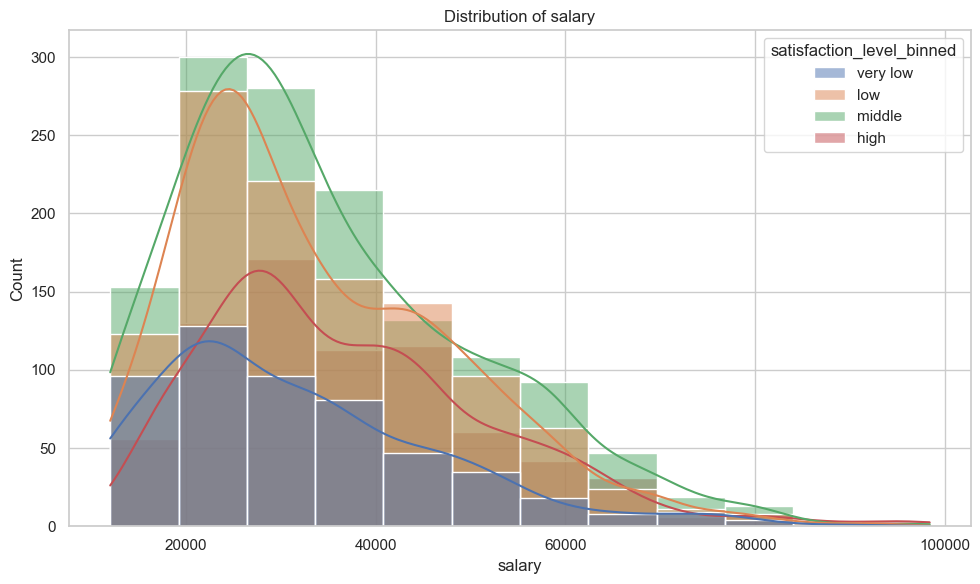

In [21]:
plt.figure()
sns.histplot(data=train_job_satisfaction, x='salary', hue=target, kde=True, bins=12)
plt.title(f'Distribution of salary')
plt.tight_layout()
plt.show()

Discrete features

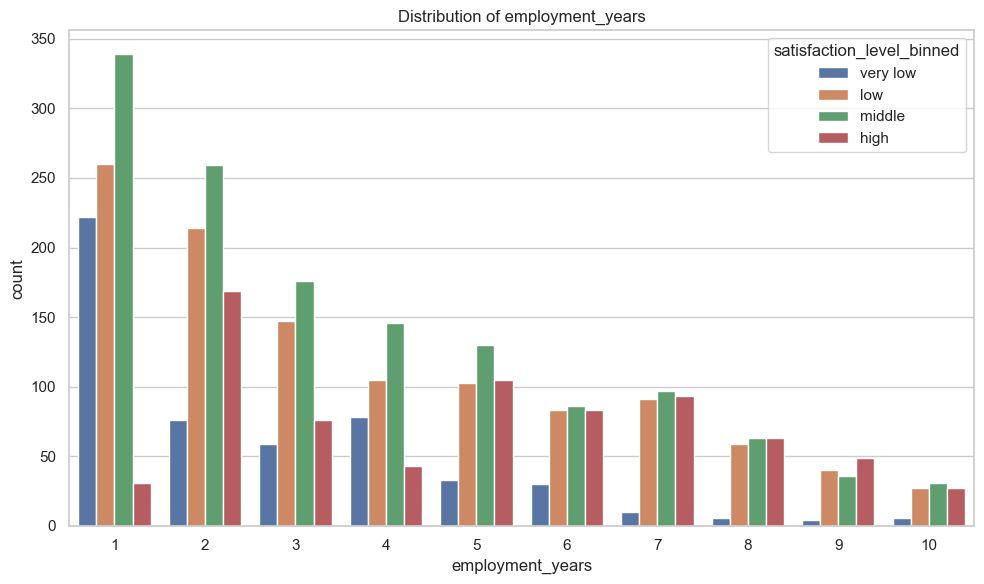

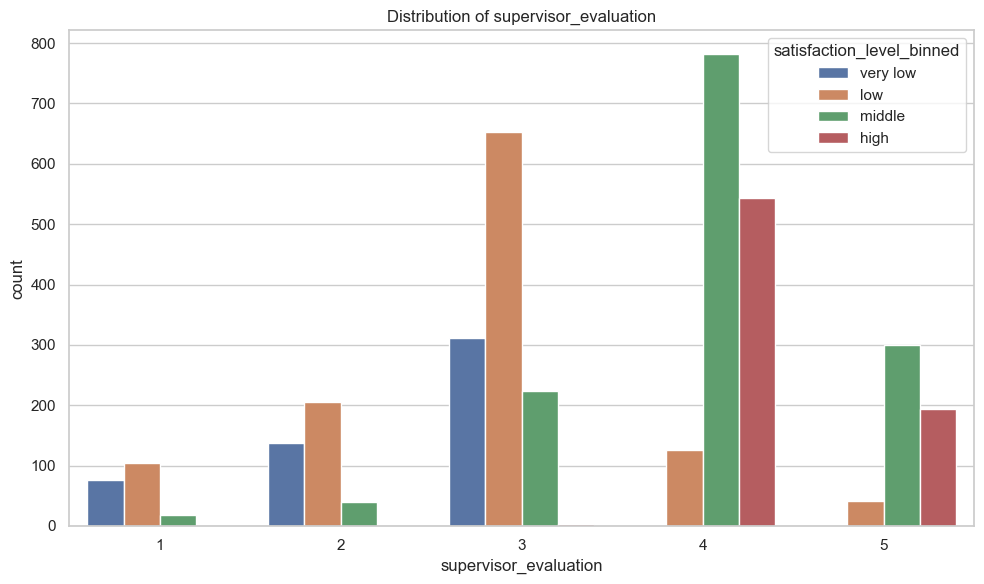

In [22]:
plt.figure()
sns.countplot(data=train_job_satisfaction, x='employment_years', hue=target)
plt.title(f'Distribution of employment_years')
plt.tight_layout()
plt.show()

plt.figure()
sns.countplot(data=train_job_satisfaction, x='supervisor_evaluation', hue=target)
plt.title(f'Distribution of supervisor_evaluation')
plt.tight_layout()
plt.show()

**Key observations**:

- Job satisfaction tends to increase with salary, although the relationship is not strictly linear. High salary does not guarantee high satisfaction.

- Employees with shorter tenure (1–3 years) demonstrate a higher proportion of very low satisfaction levels.

- Supervisor evaluation is strongly associated with job satisfaction: higher evaluations correspond to significantly higher satisfaction.

- Employees with high workload are more likely to report low or very low satisfaction.

- Junior-level employees show lower satisfaction compared to middle and senior staff.

- Employees who received promotions are more likely to belong to the high satisfaction group.

- Staff with recorded violations tend to have lower satisfaction levels.

In [23]:
interval_cols = [
    'salary',                    
    'job_satisfaction_rate',                   
    'supervisor_evaluation'
]

In [24]:
corr_matrix = train_job_satisfaction.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

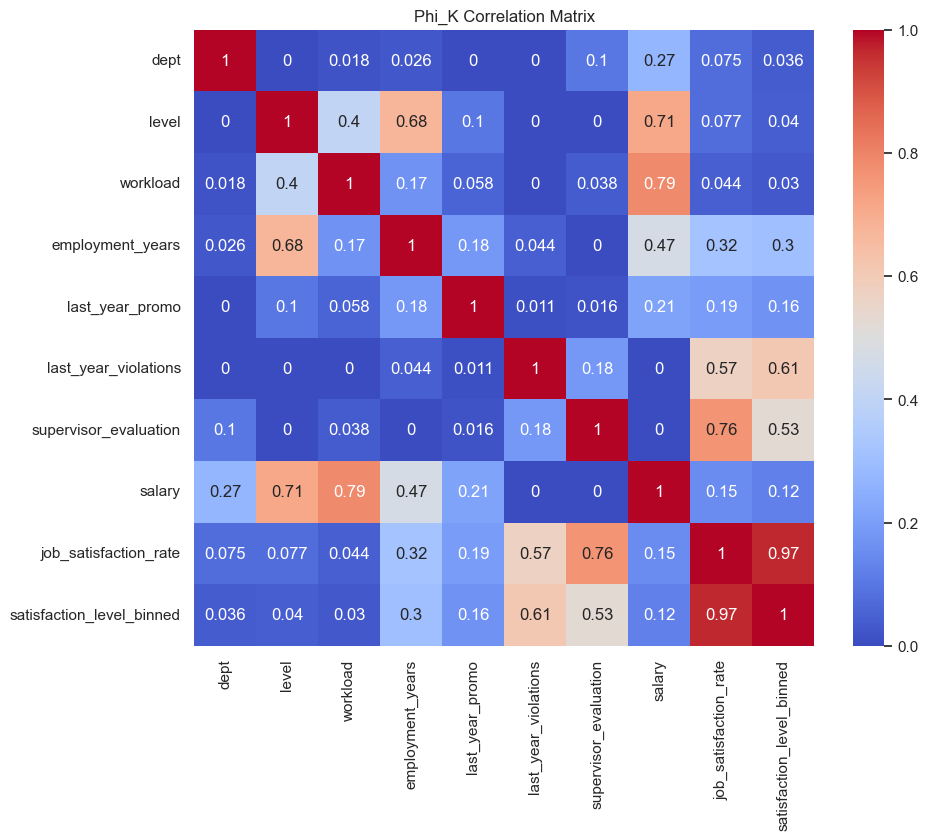

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

The Phi_K correlation matrix revealed several important relationships:

**Strong correlations**:

- job_satisfaction_rate ↔ satisfaction_level_binned (0.97) — expected due to binning.

- salary ↔ workload (0.79) — higher workload is generally associated with higher pay.

- salary ↔ level (0.72) — higher positions correspond to higher salaries.

- supervisor_evaluation ↔ job_satisfaction_rate (0.76) — management perception strongly influences satisfaction.

**Moderate correlations**:

- employment_years ↔ level (0.68) — longer tenure is linked to higher positions.

- last_year_violations ↔ job_satisfaction_rate (0.56) — employees with violations tend to be less satisfied.

**Low or insignificant correlations**:

- dept shows minimal correlation with most variables.

- last_year_promo is weakly correlated with other features.


Exploratory analysis revealed that job satisfaction is primarily influenced by salary, supervisor evaluation, workload, and tenure. Employees with high workload, low salary, low supervisor ratings, and short tenure tend to demonstrate lower satisfaction levels. Promotions and higher job levels are associated with increased satisfaction, while violations correlate with dissatisfaction. These insights highlight critical factors that should be considered when building predictive models and developing employee retention strategies.

## Data preparation

To ensure consistent data transformation and prevent data leakage, a unified preprocessing pipeline was created. The pipeline includes:
- Imputation of missing values for categorical features using the most frequent category.
- One-Hot Encoding for nominal categorical variables.
- Ordinal encoding for ordered categorical variables with predefined category hierarchy.
- Standardization of numerical features.

All transformations were implemented using `ColumnTransformer` and integrated into a single pipeline that will be applied during model training and inference.

Feature groups

In [26]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Splitting features and target

In [27]:
X_train = train_job_satisfaction.drop(['satisfaction_level_binned', 'id', 'job_satisfaction_rate'], axis=1)

In [28]:
y_train = train_job_satisfaction['job_satisfaction_rate']

In [29]:
X_test = test_features
X_test = X_test.sort_values(by='id').reset_index(drop=True)

y_test = test_target_job_satisfaction
y_test = y_test.sort_values(by='id').reset_index(drop=True)

In [30]:
print(X_test.shape)
print(y_test.shape)

(2000, 9)
(2000, 2)


Pipeline for nominal categorical features

In [31]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Pipeline for ordinal categorical features

In [32]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Pipeline for numerical features

In [33]:
num_pipe = Pipeline(
    [('num', StandardScaler())
    ]
    )

Unified preprocessing pipeline

In [34]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

A structured preprocessing pipeline was created to prepare the dataset for modeling. It ensures consistent handling of missing values, appropriate encoding of categorical features, and normalization of numerical features. This approach guarantees reproducibility and prevents data leakage during model training and evaluation.

## Model training

To identify the best-performing regression model, several algorithms were evaluated using RandomizedSearchCV with 5-fold cross-validation. The following models were tested:
- DecisionTreeRegressor
- LinearRegression
- RandomForestRegressor

The SMAPE metric was used as the evaluation criterion, as it reflects relative prediction error and aligns with the business requirement (SMAPE ≤ 15). Different preprocessing strategies for numerical features were also tested, including StandardScaler and MinMaxScaler.

Final pipeline: preprocessing + model

In [35]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Hyperparameter grid

In [36]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
    'models': [LinearRegression()],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 5, 7, 9, None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

SMAPE function

In [37]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)

    nonzero_mask = denominator != 0
    smape_value = 100 * np.mean(diff[nonzero_mask] / denominator[nonzero_mask])

    return smape_value

In [38]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Hyperparameter search

In [39]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeR...ndom_state=42)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [LinearRegression()], 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,n_iter,10
,scoring,make_scorer(s...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Results

In [40]:
cv_results = pd.DataFrame(randomized_search.cv_results_)

cv_results['mean_SMAPE'] = -cv_results['mean_test_score']
cv_results[['param_models','mean_SMAPE']].sort_values('mean_SMAPE')

,param_models,mean_SMAPE
3,RandomForestRegressor(random_state=42),13.811567
5,RandomForestRegressor(random_state=42),15.343892
0,RandomForestRegressor(random_state=42),15.346127
4,RandomForestRegressor(random_state=42),19.737334
7,DecisionTreeRegressor(random_state=42),22.747664
1,DecisionTreeRegressor(random_state=42),23.333235
2,DecisionTreeRegressor(random_state=42),23.333235
6,DecisionTreeRegressor(random_state=42),23.965105
9,DecisionTreeRegressor(random_state=42),23.965105
8,DecisionTreeRegressor(random_state=42),24.374195


In [41]:
best_model = randomized_search.best_estimator_
best_params = randomized_search.best_params_
best_cv_score = -randomized_search.best_score_

In [42]:
y_test.head()

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


Test set evaluation

In [43]:
y_pred = randomized_search.predict(X_test)

print(f'SMAPE: {smape(y_test.iloc[:, 1], y_pred)}')

SMAPE: 12.354210671876254


The RandomForestRegressor demonstrated the best performance, achieving the lowest error across cross-validation folds.

The optimal configuration included:
- Model: RandomForestRegressor
- Numerical feature scaling: MinMaxScaler
- max_depth: None

## Final conclusions

Several regression models were evaluated using RandomizedSearchCV, including DecisionTreeRegressor, LinearRegression, and RandomForestRegressor. Model performance was assessed using the SMAPE metric, which was selected in accordance with the task requirements as it reflects relative prediction accuracy.

The best performance was achieved by the RandomForestRegressor model, which produced:
- Mean SMAPE on cross-validation: 13.81  
- SMAPE on the test set: 12.35  

This result meets the business requirement (SMAPE ≤ 15), indicating that the model demonstrates good generalization and predictive quality.

**Reasons for model selection**:
- RandomForestRegressor effectively captures complex non-linear relationships in the data and performs robustly with mixed feature types.
- The use of MinMaxScaler for numerical features improved model performance compared to StandardScaler and passthrough, confirming the importance of proper feature scaling.

As a result, RandomForestRegressor combined with an optimized preprocessing pipeline was selected as the final model for predicting employee job satisfaction.

# Task 2: Predicting employee resignation

## Data loading

In [44]:
train_quit = pd.read_csv('data/train_quit.csv', sep = ',')

train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [45]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [46]:
test_features = pd.read_csv('data/test_features.csv', sep = ',')

In [47]:
test_target_quit = pd.read_csv('data/test_target_quit.csv', sep = ',')

test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [48]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Data Preprocessing

- **train_quit**

Check and remove duplicates (excluding ID column)

In [49]:
duplicates_count = train_quit.duplicated(
    subset=train_quit.columns[1:]
).sum()

train_quit = (
    train_quit
    .drop_duplicates(subset=train_quit.columns[1:])
    .reset_index(drop=True)
)

print(f"Removed {duplicates_count} duplicate rows")

Removed 1413 duplicate rows


Review unique values for categorical features

In [50]:
categorical_columns = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

for col in categorical_columns:
    print(f"Unique values in {col}: {train_quit[col].unique()}")

Unique values in dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Unique values in level: ['middle' 'junior' 'sinior']
Unique values in workload: ['high' 'medium' 'low']
Unique values in last_year_promo: ['no' 'yes']
Unique values in last_year_violations: ['no' 'yes']


In [51]:
train_quit['level'] = train_quit['level'].replace(
    {'sinior': 'senior'}
)

Since the test dataset (`test_features`) is identical for both tasks, it was not reprocessed in this stage. All preprocessing steps applied in Task 1 remain valid and are reused to ensure consistency and comparability between the two predictive models. Only the training data (`train_quit`) was additionally cleaned and prepared for the employee resignation prediction task.

The dataset was cleaned by removing duplicate records and validating categorical feature values. An identified spelling issue in the level column was corrected to ensure data consistency before further processing.

## Exploratory Data Analysis (EDA)

### Exploratory Data Analysis (EDA)

In [52]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000,2587.000000
mean,554113.752223,4.213375,3.367994,37107.692308
std,259792.465393,2.601105,1.080243,16267.354906
min,100222.000000,1.000000,1.000000,12000.000000
25%,332422.000000,2.000000,3.000000,24000.000000
50%,550402.000000,4.000000,3.000000,33600.000000
75%,780634.500000,6.000000,4.000000,46800.000000
max,999915.000000,10.000000,5.000000,96000.000000


Categorical features

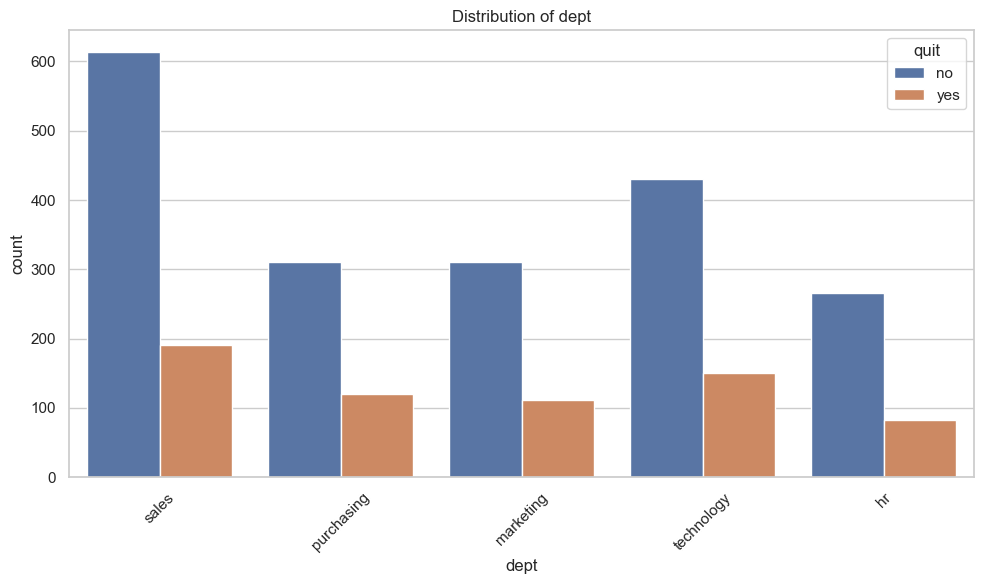

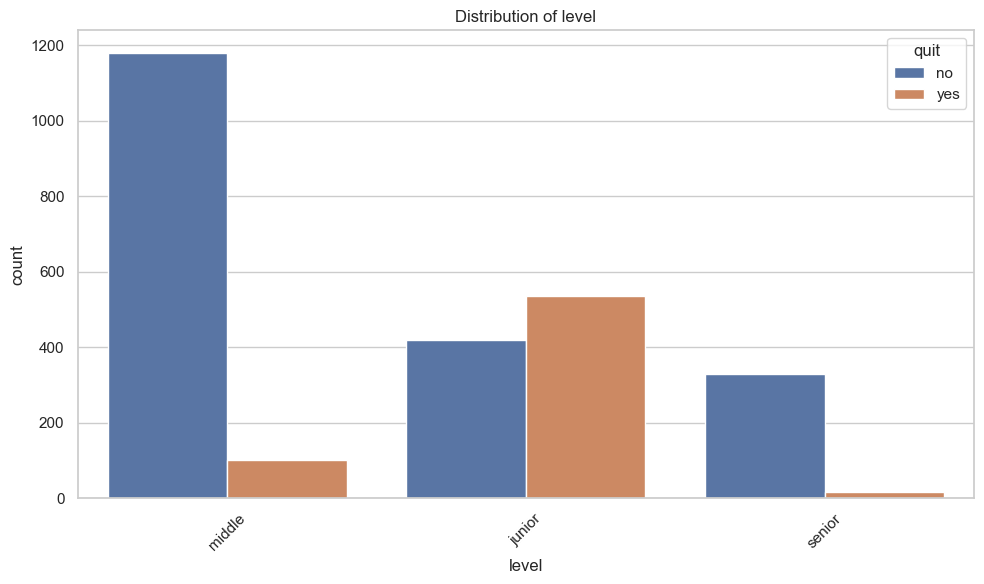

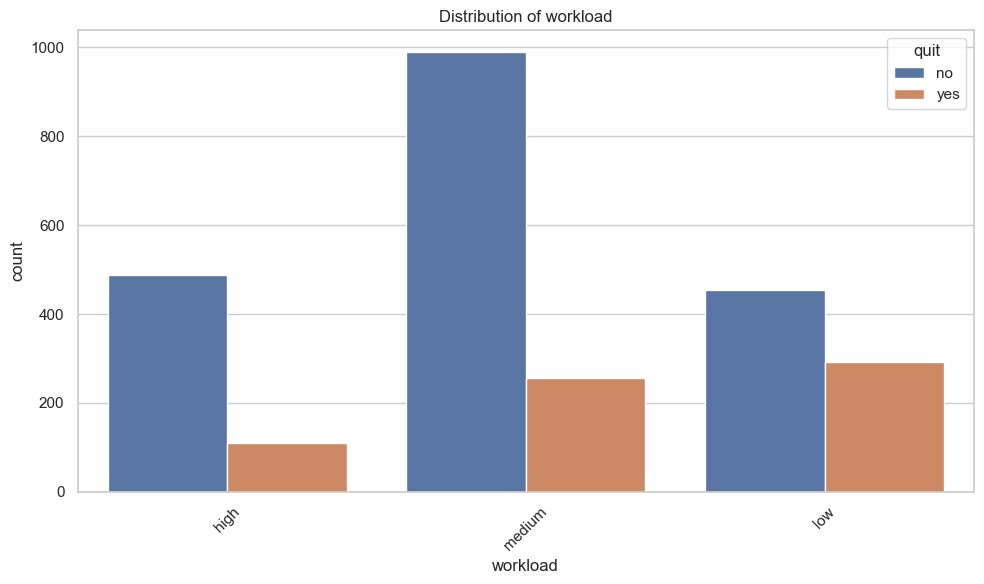

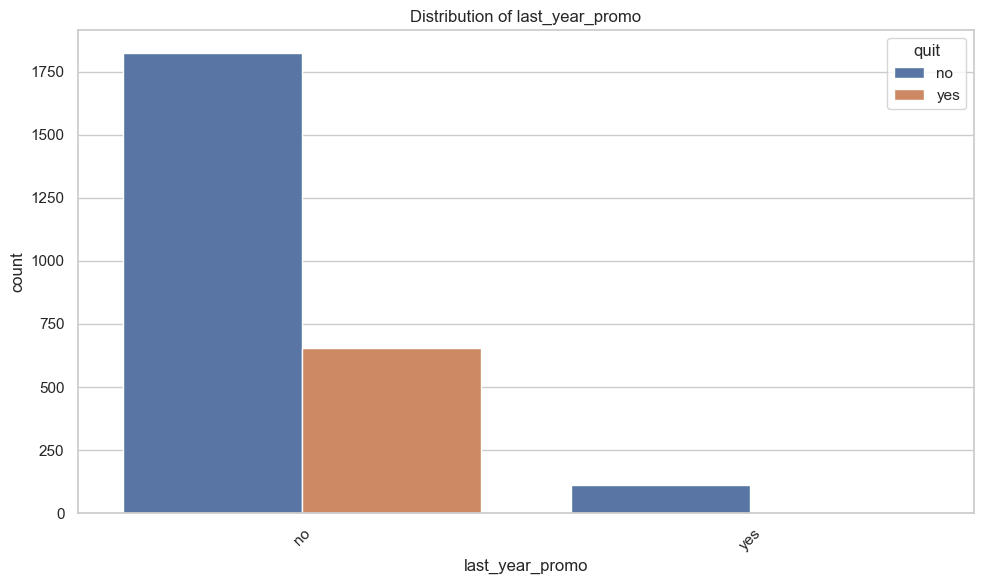

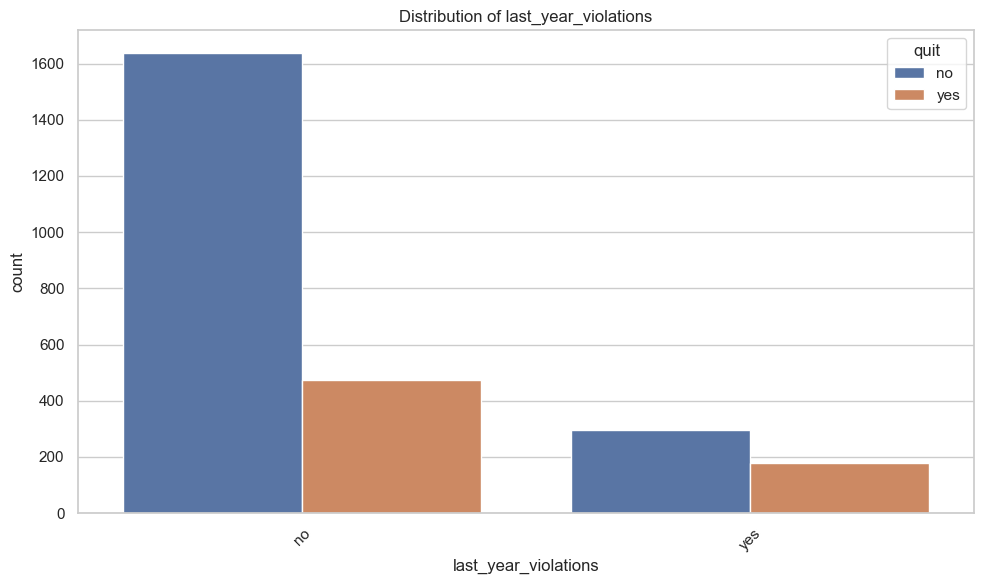

In [53]:
target = 'quit'

for col in cat_features:
    plt.figure()
    sns.countplot(data=train_quit, x=col, hue=target)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Numerical features

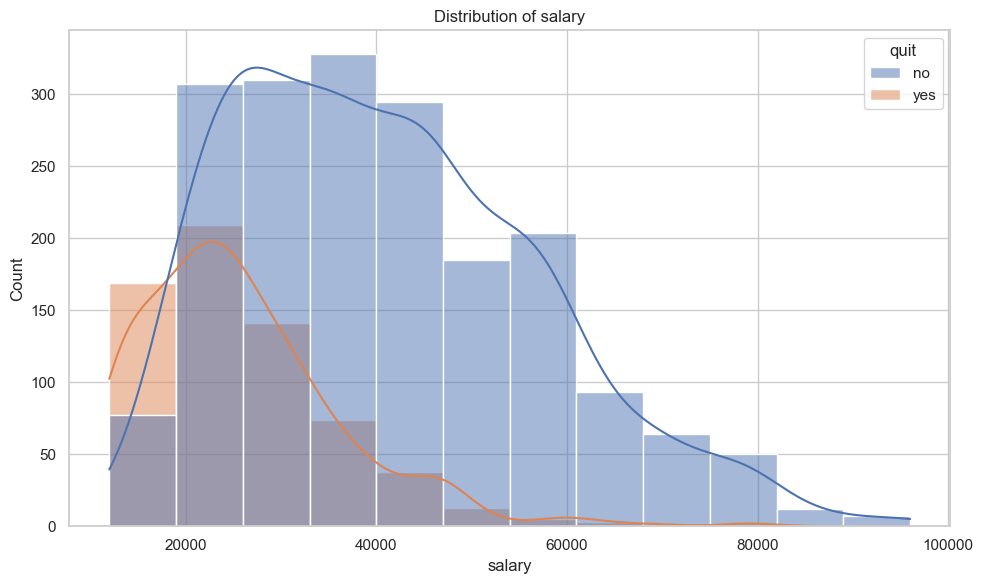

In [54]:
plt.figure()
sns.histplot(data=train_quit, x='salary', hue=target, kde=True, bins=12)
plt.title(f'Distribution of salary')
plt.tight_layout()
plt.show()

Discrete features

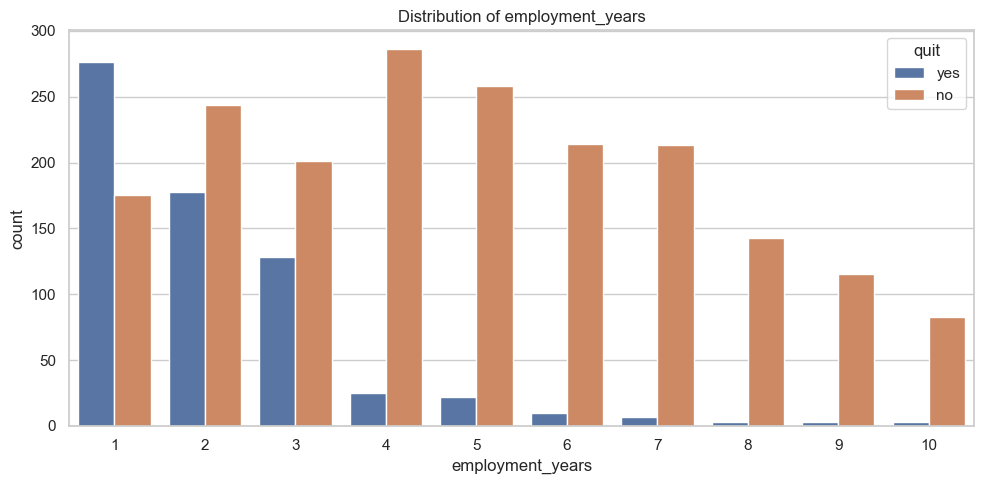

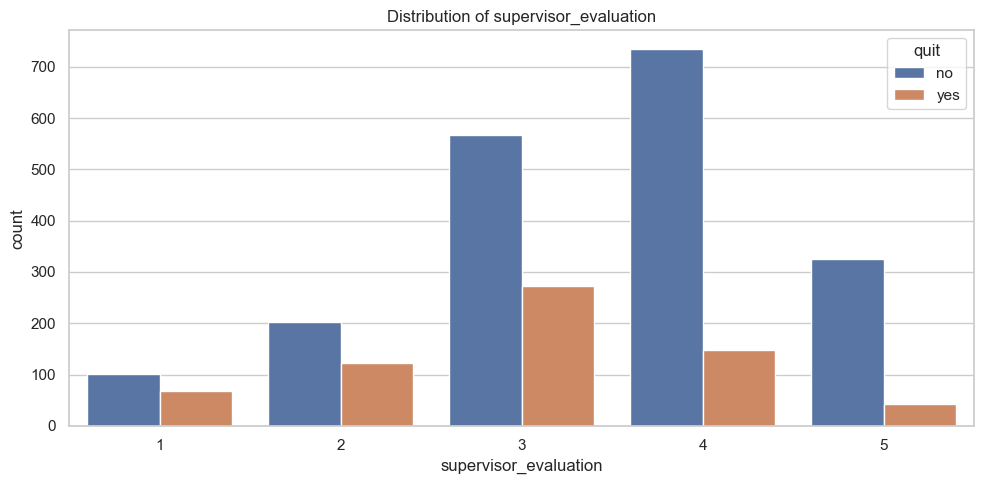

In [55]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


plt.figure()
sns.countplot(data=train_quit, x='employment_years', hue=target)
plt.title(f'Distribution of employment_years')
plt.tight_layout()
plt.show()

plt.figure()
sns.countplot(data=train_quit, x='supervisor_evaluation', hue=target)
plt.title(f'Distribution of supervisor_evaluation')
plt.tight_layout()
plt.show()

**Key insights**:

- The highest employee resignation rate is observed in the Sales department, indicating a potentially problematic area that may require closer attention from HR and management.

- Junior employees demonstrate the highest likelihood of leaving the company, while resignations among senior staff are minimal, suggesting stronger retention at higher job levels.

- Employees who did not receive a promotion in the previous year are more likely to resign, highlighting the importance of career development and advancement opportunities.

- Staff members with recorded violations tend to leave the company more frequently, which may reflect dissatisfaction or disciplinary consequences.

- Lower salary levels are strongly associated with higher resignation rates, whereas employees with higher income show significantly greater retention.

- Resignations are most common among employees with short tenure (1 year), with a sharp decline in resignation probability as years of employment increase.

- Lower supervisor evaluations correlate with higher likelihood of resignation, indicating that performance feedback and managerial relationships play an important role in retention.

### Profile of employees likely to leave

- More frequent among employees with low satisfaction scores  
- Strong association with low supervisor evaluations  
- Higher turnover among employees with short tenure  
- Concentrated in Sales and Junior segments  
- Employees without recent promotions are more likely to resign

### Comparison of job satisfaction between resigned and retained employees

Merging the tables

In [56]:
merged = test_target_quit.merge(test_target_job_satisfaction, on='id')

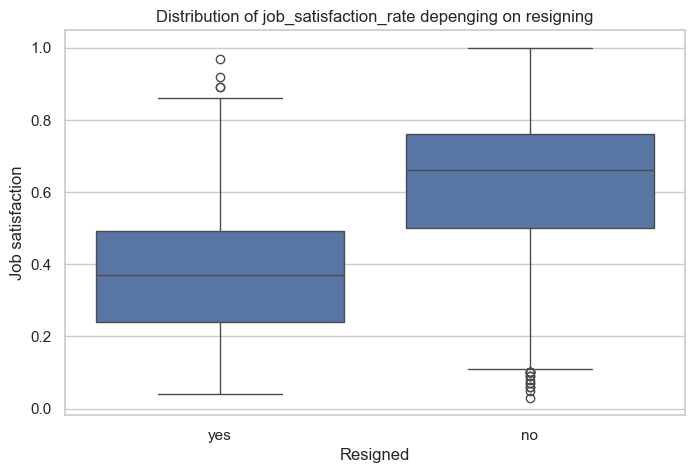

In [57]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x='quit', y='job_satisfaction_rate')
plt.title('Distribution of job_satisfaction_rate depenging on resigning')
plt.xlabel('Resigned')
plt.ylabel('Job satisfaction')
plt.show()

The boxplot comparison demonstrates a clear difference in job satisfaction levels between resigned and retained employees.

Employees who left the company show a significantly lower median job satisfaction (0.4) compared to those who remained (0.7). The distribution for resigned employees is more dispersed and shifted towards lower values, indicating that low job satisfaction is strongly associated with resignation. Although a small number of resigned employees exhibit high satisfaction scores, these cases are outliers.

In [58]:
interval_cols = [
    'salary',                    
    'job_satisfaction_rate',                   
    'supervisor_evaluation',
    'quit'
]

In [59]:
corr_matrix = train_job_satisfaction.drop(columns=['id']).phik_matrix(interval_cols=interval_cols)

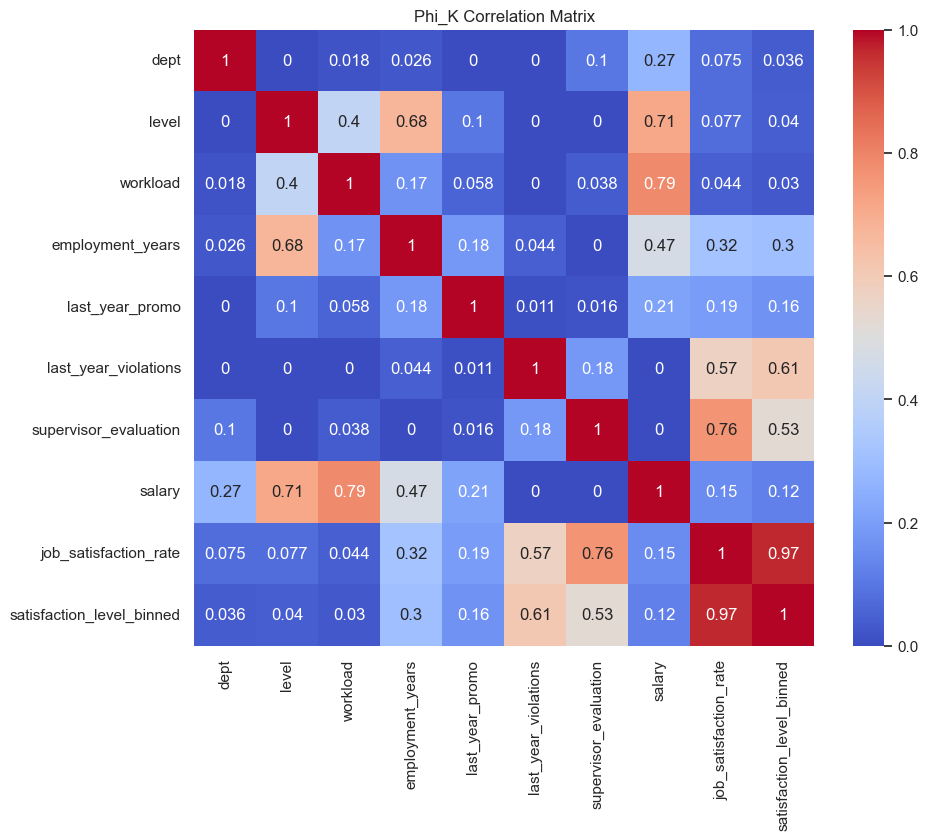

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

The Phi-K correlation matrix revealed several important relationships:

**Strong correlations:**
- job_satisfaction_rate ↔ supervisor_evaluation (0.76) — strong influence of managerial evaluation on employee satisfaction.
- salary ↔ workload (0.79) and salary ↔ level (0.72) — higher job levels and workload correspond to higher salaries.
- job_satisfaction_rate ↔ satisfaction_level_binned (0.97) — expected due to binning.

**Moderate correlations:**
- employment_years ↔ level (0.68) — longer tenure is linked to higher job positions.
- last_year_violations ↔ job_satisfaction_rate (0.56) — employees with violations tend to demonstrate lower satisfaction.

**Weak correlations:**
- dept and last_year_promo show limited direct correlation with other features, suggesting a weaker individual impact on resignation decisions.

## Feature engineering: Adding predicted job satisfaction

In [61]:
X_train = train_quit.drop(['id', 'quit'], axis=1)

In [62]:
X_test = test_features

In [63]:
train_quit['job_satisfaction_rate'] = randomized_search.predict(X_train)

In [64]:
test_features['job_satisfaction_rate'] = randomized_search.predict(X_test)

C:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Data preparation

Feature groups

In [65]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Splitting features and target

In [66]:
X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']

X_test = test_features
X_test = X_test.sort_values(by='id').reset_index(drop=True)

y_test = test_target_quit
y_test = y_test.sort_values(by='id').reset_index(drop=True)

In [67]:
le = LabelEncoder()
y_test_bin = le.fit_transform(y_test['quit'])

Pipeline for nominal categorical features

In [68]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Pipeline for ordinal categorical features 

In [69]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Pipeline for numerical features

In [70]:
num_pipe = Pipeline(
    [('num', StandardScaler())
    ]
    )

Unified preprocessing pipeline

In [71]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

At this stage, input features were prepared for training the employee resignation prediction model. Categorical variables were divided into nominal and ordinal groups and encoded using OneHotEncoder and OrdinalEncoder, respectively. Numerical features, including the newly introduced predicted job satisfaction score, were standardized using scaling techniques.

Missing values were handled within the preprocessing pipeline using SimpleImputer to ensure consistent and reliable transformations. All preprocessing steps were integrated using ColumnTransformer and Pipeline, providing a structured, reproducible, and leakage-safe data transformation workflow suitable for machine learning models.

## Model training

To identify the best-performing regression model, several algorithms were evaluated using RandomizedSearchCV with 5-fold cross-validation. The following models were tested:

- DecisionTreeClassifier
- LogisticRegression
- RandomForestClassifier

Final pipeline: preprocessing + model

In [72]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Hyperparameter grid

In [73]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10, None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


Hyperparameter search

In [74]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [LogisticRegre...r='liblinear')], 'models__C': range(1, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Results

In [75]:
cv_results = pd.DataFrame(randomized_search.cv_results_)

cv_results['mean_roc_auc'] = -cv_results['mean_test_score']
cv_results[['param_models','mean_roc_auc']].sort_values('mean_roc_auc')

,param_models,mean_roc_auc
8,RandomForestClassifier(random_state=42),-0.903567
2,"LogisticRegression(penalty='l1', random_state=...",-0.902907
4,"LogisticRegression(penalty='l1', random_state=...",-0.902880
7,"LogisticRegression(penalty='l1', random_state=...",-0.902714
6,"LogisticRegression(penalty='l1', random_state=...",-0.902583
5,RandomForestClassifier(random_state=42),-0.884806
9,DecisionTreeClassifier(random_state=42),-0.863067
3,DecisionTreeClassifier(random_state=42),-0.863067
1,DecisionTreeClassifier(random_state=42),-0.824614
0,DecisionTreeClassifier(random_state=42),-0.656322


In [76]:
best_model = randomized_search.best_estimator_
best_params = randomized_search.best_params_
best_cv_score = -randomized_search.best_score_

Test set evaluation

In [77]:
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]

print(f'ROC-AUC: {roc_auc_score(y_test_bin, y_test_proba):.4f}')

ROC-AUC: 0.9276


C:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Three classification models were evaluated for the employee resignation prediction task: DecisionTreeClassifier, LogisticRegression, and RandomForestClassifier. For each model, hyperparameters were tuned using RandomizedSearchCV with 5-fold cross-validation and ROC-AUC as the primary evaluation metric. Different preprocessing strategies for numerical features (StandardScaler, MinMaxScaler, and no scaling) were also tested.

The best-performing model was RandomForestClassifier with the following configuration:
- n_estimators = 100  
- max_depth = 10  
- MinMaxScaler applied to numerical features  

The model achieved:
- Cross-validation ROC-AUC: 0.93  
- Test ROC-AUC: 0.93  

This exceeds the target quality threshold of 0.9 and indicates a strong ability to distinguish between employees who are likely to stay and those at risk of resignation. Proper hyperparameter tuning and feature scaling contributed to the final performance of the model.

## Final conclusions

Among the tested models, RandomForestClassifier demonstrated the best performance. It achieved a ROC-AUC score of 0.9261 on the test set, exceeding the target threshold of 0.9 and confirming the model’s strong predictive capability.

Compared to DecisionTreeClassifier and LogisticRegression, the Random Forest model proved more robust and better at capturing complex non-linear patterns in the data. Its ensemble nature reduces variance and improves generalization, making it well-suited for this classification task.

Additional performance gains were achieved through proper feature scaling using StandardScaler and systematic hyperparameter tuning via cross-validation.

Therefore, RandomForestClassifier with optimized parameters was selected as the final model for predicting employee resignation risk.

# Overall Conclusions

This project addressed two interconnected HR analytics tasks: predicting employee job satisfaction and forecasting employee resignation risk.

In Task 1, a regression model was developed to estimate job satisfaction levels. RandomForestRegressor demonstrated the best performance, achieving a SMAPE of 12.37 on the test set, which met the project requirement (SMAPE ≤ 15). The model successfully captured key factors influencing satisfaction, such as salary, supervisor evaluation, workload, and job level.

In Task 2, a classification model was built to predict employee resignation. To enhance predictive power, the estimated job satisfaction score from Task 1 was incorporated as an additional feature. This approach significantly improved model performance and allowed the model to better capture the underlying relationship between dissatisfaction and resignation behaviour. The best-performing model — RandomForestClassifier — achieved a ROC-AUC score of 0.9261 on the test set, exceeding the target threshold of 0.9 and confirming strong discriminatory capability. The analysis demonstrated that employee resignation is closely linked to low job satisfaction, junior job level, low salary, lack of promotion, and short tenure.

Together, these two models provide a coherent analytical framework for understanding and predicting employee experience and turnover risk.

## Business impact

The results of this project provide actionable value for HR and management teams by enabling data-driven workforce decisions.

**Key potential business applications include**:

- Early identification of employees at high risk of resignation, allowing for proactive retention strategies.
- Targeted HR interventions such as personalized career development plans, workload redistribution, and performance feedback improvements.
- Optimization of compensation and promotion policies based on predictive insights.
- Reduction of employee turnover costs, including recruitment, onboarding, and productivity loss.
- Strategic workforce planning by identifying structural weaknesses within specific departments or employee groups.

By using predictive analytics, the company can shift from reactive to preventive HR management, improving overall employee engagement, productivity, and long-term organizational stability.